<a href="https://colab.research.google.com/github/jimitogni/ml_study/blob/master/monkeys_bread.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

In [0]:
os.environ['KAGLE_USERNAME']= "jimitogni"
os.environ['KAGLE_KEY']= "6ba3f466a063e70addd26514bb2cf41d"

In [0]:
%%shell

export KAGGLE_USERNAME=jimitogni
export KAGGLE_KEY=6ba3f466a063e70addd26514bb2cf41d

kaggle datasets download slothkong/10-monkey-species

 95% 521M/547M [00:10<00:00, 30.2MB/s]
100% 547M/547M [00:10<00:00, 53.0MB/s]


In [0]:
!unzip 10-monkey-species.zip

Archive:  10-monkey-species.zip
  inflating: monkey_labels.txt       
  inflating: training/training/n0/n0018.jpg  
  inflating: training/training/n0/n0019.jpg  
  inflating: training/training/n0/n0020.jpg  
  inflating: training/training/n0/n0021.jpg  
  inflating: training/training/n0/n0022.jpg  
  inflating: training/training/n0/n0023.jpg  
  inflating: training/training/n0/n0024.jpg  
  inflating: training/training/n0/n0025.jpg  
  inflating: training/training/n0/n0026.jpg  
  inflating: training/training/n0/n0027.jpg  
  inflating: training/training/n0/n0028.jpg  
  inflating: training/training/n0/n0029.jpg  
  inflating: training/training/n0/n0030.jpg  
  inflating: training/training/n0/n0031.jpg  
  inflating: training/training/n0/n0032.jpg  
  inflating: training/training/n0/n0033.jpg  
  inflating: training/training/n0/n0034.jpg  
  inflating: training/training/n0/n0035.jpg  
  inflating: training/training/n0/n0036.jpg  
  inflating: training/training/n0/n0037.jpg  
  inflatin

In [0]:
from keras.applications import MobileNet
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [0]:
img_rows, img_cols = 224, 224

MobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #largura, altura, 3=RGB colorido

for layer in MobileNet.layers:
  layer.trainable=False


In [0]:
# lista as camadas que definimos para usar com entrada 0 InputLayer False
# todos estão como false, pois não vamos treina-los, quando utilizamos "layer.trainable=False" acima
for (i, layer) in enumerate(MobileNet.layers): #pega os layers da mobilenet e coloca em payer e o i fica como index
  print(str(i),layer.__class__.__name__,layer.trainable)

In [0]:
#criando o nosso top layer
def addTopModelMobileNet(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dropout(0,2)(top_model)
  top_model = Dense(num_classes, activation='softmax')(top_model)

  return top_model

In [142]:
num_classes = 10

FC = addTopModelMobileNet(MobileNet, num_classes) #MobileNet = bottom_model
model = Model(input=MobileNet.input, output=FC) #bottom layers, top layer

#model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [0]:
train_data_dir = '/content/training/training/'
validation_data_dir = '/content/validation/validation/'

In [144]:
#data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [145]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('macacos_modelo.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:680: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


In [0]:
nb_train_samples = 1098
nb_validation_samples = 272

epochs = 50
batch_size = 32

In [147]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)

Epoch 1/50
34/34 [==============================] - 38s 1s/step - loss: 1.2327 - accuracy: 0.5769 - val_loss: 0.5532 - val_accuracy: 0.8633

Epoch 00001: val_loss improved from inf to 0.55321, saving model to macacos_modelo.h5
Epoch 2/50
34/34 [==============================] - 38s 1s/step - loss: 0.3672 - accuracy: 0.8827 - val_loss: 0.4355 - val_accuracy: 0.8750

Epoch 00002: val_loss improved from 0.55321 to 0.43545, saving model to macacos_modelo.h5
Epoch 3/50
34/34 [==============================] - 37s 1s/step - loss: 0.3343 - accuracy: 0.8724 - val_loss: 0.2851 - val_accuracy: 0.8917

Epoch 00003: val_loss improved from 0.43545 to 0.28506, saving model to macacos_modelo.h5
Epoch 4/50
34/34 [==============================] - 37s 1s/step - loss: 0.2982 - accuracy: 0.8940 - val_loss: 0.8536 - val_accuracy: 0.8792

Epoch 00004: val_loss did not improve from 0.28506
Epoch 5/50
34/34 [==============================] - 37s 1s/step - loss: 0.2651 - accuracy: 0.9081 - val_loss: 0.3135 - 


------ RESULTADOS ------



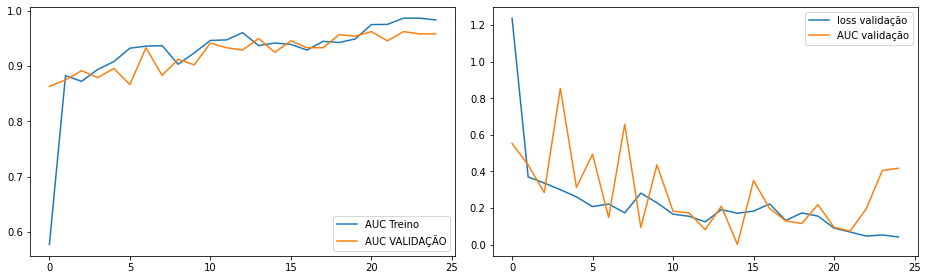



Com os valores:
batch size: 32 - Epocas: 50


In [151]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

In [0]:
# TESTANDO

In [0]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

model = load_model('/content/macacos_modelo.h5')

img_rows, img_cols = 224, 224

In [0]:
class_labels = [
	'mantled_howler', 
	'patas_monkey', 
	'bald_uakari', 
	'japanese_macaque', 
	'pygmy_marmoset', 
	'white_headed_capuchin',
	'silvery_marmoset',
	'common_squirrel_monkey', 
	'black_headed_night_monkey',
	'nilgiri_langur' 
	]

In [0]:
def check(patch):
  #prediction
  img = image.load_img(patch, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x.astype('float32')/255
  pred = np.argmax(model.predict(x))

  print("isso é um = {} ".format(class_labels[pred]))

In [0]:
!wget url -P /content/macacos/ https://www.monkeyworlds.com/wp-content/uploads/pygmy.jpg


--2020-05-02 23:18:28--  http://url/
Resolving url (url)... failed: Name or service not known.
wget: unable to resolve host address ‘url’
--2020-05-02 23:18:28--  https://www.monkeyworlds.com/wp-content/uploads/pygmy.jpg
Resolving www.monkeyworlds.com (www.monkeyworlds.com)... 159.203.148.90
Connecting to www.monkeyworlds.com (www.monkeyworlds.com)|159.203.148.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39103 (38K) [image/jpeg]
Saving to: ‘/content/macacos/pygmy.jpg’

pygmy.jpg           100%[===================>]  38.19K  --.-KB/s    in 0s      

2020-05-02 23:18:28 (376 MB/s) - ‘/content/macacos/pygmy.jpg’ saved [39103/39103]

FINISHED --2020-05-02 23:18:28--
Total wall clock time: 0.4s
Downloaded: 1 files, 38K in 0s (376 MB/s)


In [0]:
check('/content/macacos/pygmy.jpg')

isso é um = pygmy_marmoset 


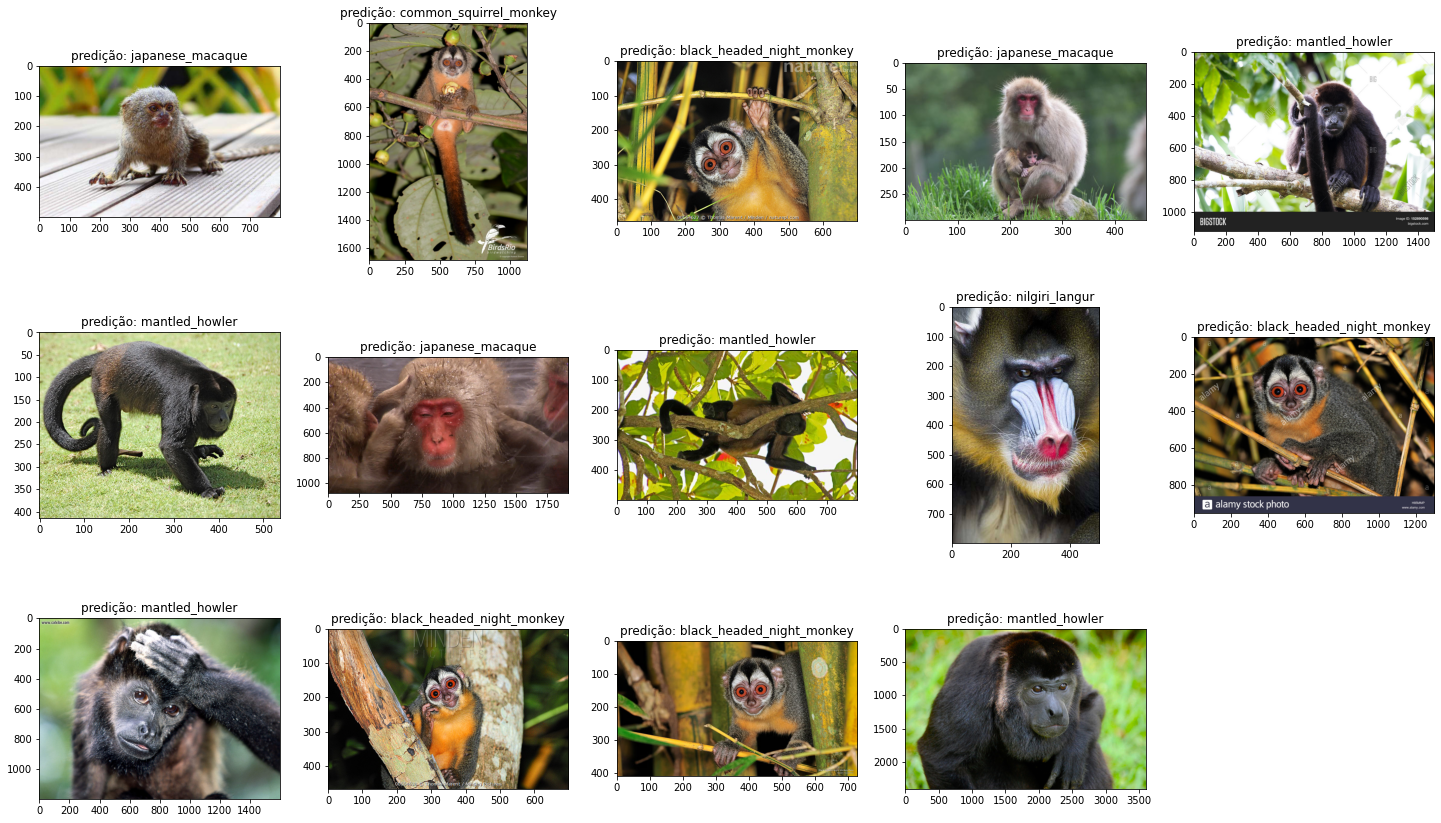

In [155]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import os

#auxilia ao plotar imagens
counter = 1
num = 15
#print(type(train_dir))

fig = plt.figure(figsize=(25,20))
#print("antes do for")
#print("list_dir train_dir = {}".format(os.listdir(train_dir)))
#print("train_dir + file = {}".format(os.listdir(train_dir + file)))

for file in os.listdir('/content/macacos/'):
  #print('dataset/train/covid/' + file)
  if file.endswith(".jpg"):
    #print("passou no if 1")
    if counter == num:
      #print("parrou no if 2 - nao achou nada")
      break

    #print("chegou até o final do for")

    img = image.load_img('/content/macacos/' + file, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x.astype('float32')/255
    pred = np.argmax(model.predict(x))

    img_name = mpimg.imread('/content/macacos/' + file)
    plt.subplot(4,5,counter)
    plt.title("predição: {}".format(class_labels[pred]))
    imgplot = plt.imshow(img_name)

    counter += 1
    #print("chegou até o final do for")